# Adult Census Income

In [3]:
import zipfile
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE  # For handling class imbalance
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

In [4]:
# Extract the zip file
zip_file_path = 'Adult Census Income.zip'
extract_path = 'adult_income_data'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Load the dataset
file_path = os.path.join(extract_path, 'adult.csv')
df = pd.read_csv(file_path)

# Display dataset information
print("Dataset Information:")
print(df.info())
print("\nFirst few rows:")
print(df.head())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
None

First few rows:
   age workclass  fnlwgt     education  education.

In [5]:
# Inspect and Clean the Dataset

# Replace '?' with NaN for missing value handling
df.replace('?', pd.NA, inplace=True)

# Drop rows with missing values
print(f"\nNumber of rows before dropping missing values: {len(df)}")
df.dropna(inplace=True)
print(f"Number of rows after dropping missing values: {len(df)}")

# Display unique values in categorical columns to confirm cleaning
for col in df.select_dtypes(include=['object']).columns:
    print(f"\nUnique values in '{col}': {df[col].unique()}")


Number of rows before dropping missing values: 32561
Number of rows after dropping missing values: 30162

Unique values in 'workclass': ['Private' 'State-gov' 'Federal-gov' 'Self-emp-not-inc' 'Self-emp-inc'
 'Local-gov' 'Without-pay']

Unique values in 'education': ['HS-grad' '7th-8th' 'Some-college' '10th' 'Doctorate' 'Prof-school'
 'Bachelors' 'Masters' '11th' 'Assoc-voc' '1st-4th' '5th-6th' 'Assoc-acdm'
 '12th' '9th' 'Preschool']

Unique values in 'marital.status': ['Widowed' 'Divorced' 'Separated' 'Never-married' 'Married-civ-spouse'
 'Married-spouse-absent' 'Married-AF-spouse']

Unique values in 'occupation': ['Exec-managerial' 'Machine-op-inspct' 'Prof-specialty' 'Other-service'
 'Adm-clerical' 'Transport-moving' 'Sales' 'Craft-repair'
 'Farming-fishing' 'Tech-support' 'Protective-serv' 'Handlers-cleaners'
 'Armed-Forces' 'Priv-house-serv']

Unique values in 'relationship': ['Not-in-family' 'Unmarried' 'Own-child' 'Other-relative' 'Husband' 'Wife']

Unique values in 'race': ['Wh

In [6]:
# One-Hot Encoding and Normalization

# Identify categorical and numerical columns
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("\nCategorical Columns:", categorical_columns)
print("\nNumerical Columns:", numerical_columns)

# One-hot encode categorical columns (excluding the target column)
encoder = OneHotEncoder(drop='first', sparse_output=False)  # Use 'sparse_output' for newer versions
categorical_encoded = encoder.fit_transform(df[categorical_columns[:-1]])  # Exclude target column
categorical_encoded_df = pd.DataFrame(categorical_encoded, columns=encoder.get_feature_names_out(categorical_columns[:-1]))

# Normalize numerical columns
scaler = StandardScaler()
numerical_scaled = scaler.fit_transform(df[numerical_columns])
numerical_scaled_df = pd.DataFrame(numerical_scaled, columns=numerical_columns)

# Combine preprocessed data
X = pd.concat([numerical_scaled_df, categorical_encoded_df], axis=1)
y = df['income'].map({'<=50K': 0, '>50K': 1})  # Map target to binary values


Categorical Columns: ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country', 'income']

Numerical Columns: ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']


In [7]:
# Address Class Imbalance

print(f"\nClass distribution before SMOTE:\n{y.value_counts()}")

# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print(f"\nClass distribution after SMOTE:\n{pd.Series(y_resampled).value_counts()}")


Class distribution before SMOTE:
income
0    22654
1     7508
Name: count, dtype: int64

Class distribution after SMOTE:
income
0    22654
1    22654
Name: count, dtype: int64


In [8]:
# Split the Data into Training and Testing Sets

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

print("\nTraining and Testing sets created.")
print(f"Training set size: {X_train.shape[0]} rows")
print(f"Testing set size: {X_test.shape[0]} rows")


Training and Testing sets created.
Training set size: 36246 rows
Testing set size: 9062 rows



Logistic Regression Model Accuracy: 0.8333

Logistic Regression Classification Report:
              precision    recall  f1-score   support

       <=50K       0.86      0.80      0.83      4554
        >50K       0.81      0.86      0.84      4508

    accuracy                           0.83      9062
   macro avg       0.83      0.83      0.83      9062
weighted avg       0.83      0.83      0.83      9062



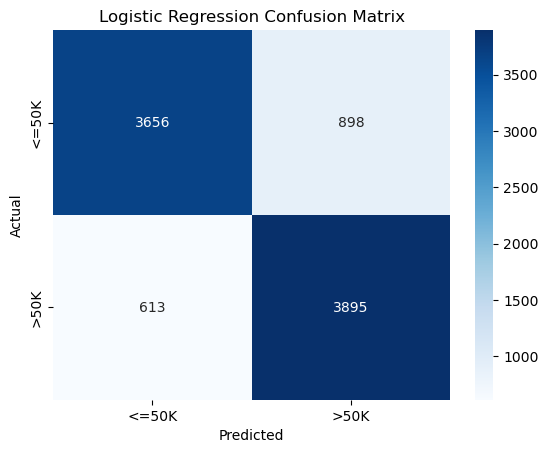


Random Forest Model Accuracy: 0.8986

Random Forest Classification Report:
              precision    recall  f1-score   support

       <=50K       0.91      0.88      0.90      4554
        >50K       0.88      0.92      0.90      4508

    accuracy                           0.90      9062
   macro avg       0.90      0.90      0.90      9062
weighted avg       0.90      0.90      0.90      9062



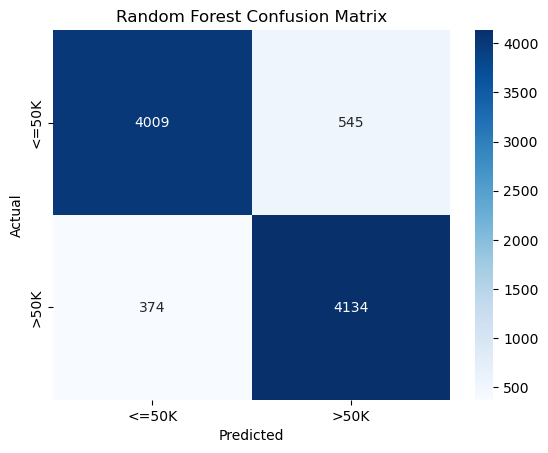

In [9]:
# Train and Evaluate Models

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)

log_accuracy = accuracy_score(y_test, y_pred_log)
print(f"\nLogistic Regression Model Accuracy: {log_accuracy:.4f}")

print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log, target_names=['<=50K', '>50K']))

# Confusion Matrix for Logistic Regression
conf_matrix_log = confusion_matrix(y_test, y_pred_log)
sns.heatmap(conf_matrix_log, annot=True, fmt='d', cmap='Blues',
            xticklabels=['<=50K', '>50K'],
            yticklabels=['<=50K', '>50K'])
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"\nRandom Forest Model Accuracy: {rf_accuracy:.4f}")

print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['<=50K', '>50K']))

# Confusion Matrix for Random Forest
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['<=50K', '>50K'],
            yticklabels=['<=50K', '>50K'])
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [10]:
# Save the Trained Model
joblib.dump(rf_model, 'adult_income_rf_model.pkl')
print("\nRandom Forest Model saved as 'adult_income_rf_model.pkl'.")


Random Forest Model saved as 'adult_income_rf_model.pkl'.


In [ ]:
# Future Improvements

# Perform hyperparameter tuning for Logistic Regression and Random Forest.
# Experiment with ensemble models like Gradient Boosting or LightGBM.
# Analyze feature importance using SHAP or LIME for better interpretability.